# Using transfer learning to analyze chromatograms for binary classification





# Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torchvision
import torch
from torch import nn
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision.utils import make_grid

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

import importlib.util
from google.colab import drive, files
from pathlib import Path
import os
from PIL import Image
import random
import pathlib
import gc

import time
import copy
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

In [2]:
!unzip -q experiment.zip

In [7]:
!pip install lightning
!pip install timm
import timm

In [4]:
if int(torchvision.__version__.split(sep = '.')[1]) < 13:
    !conda uninstall pytorch
    !pip uninstall torch --yes
    !pip uninstall torch --yes# run this command twice

    !conda uninstall torchvision
    !pip uninstall torchvision --yes
    !pip uninstall torchvision --yes # run this command twice

    !conda install --yes pytorch torchvision
    import torch
    import torchvision
    print(f'Current version of torch: {torch.__version__}')
    print(f'Current version of torchvision: {torchvision.__version__}')

else:
    import torch
    import torchvision
    print(f'Current version of torch: {torch.__version__}')
    print(f'Current version of torchvision: {torchvision.__version__}')

Current version of torch: 2.1.0+cu118
Current version of torchvision: 0.16.0+cu118


In [5]:
if importlib.util.find_spec('torchinfo') is None:
  print('torchinfo' +" is not installed")
  !pip install torchinfo
  from torchinfo import summary
  from tqdm.auto import tqdm
else:
  from torchinfo import summary
  from tqdm.auto import tqdm

torchinfo is not installed


In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
  print(torch.cuda.get_device_name(0))
device

Tesla T4


'cuda'

Image class: Metformin
Image height: 1200
Image width: 1200


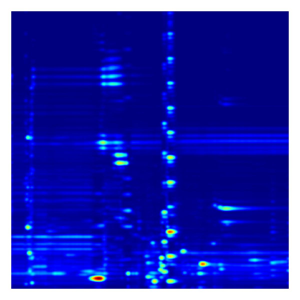

In [8]:
# taking a look at a random image

img_path = Path('/content/experiment')
train_dir = img_path / 'train'
val_dir = img_path / 'val'

image_path_list = list(img_path.glob("*/*/*.jpeg"))
random_image_path = random.choice(image_path_list)
random_image_path_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f'Image class: {random_image_path_class}')
print(f'Image height: {img.height}')
print(f'Image width: {img.width}')

img.resize((300, 300))

In [9]:
print('Number of items in the train directory:')
for pth in train_dir.iterdir():
  print(len(list(pth.glob("*.jpeg"))))

# print('Number of items in the test directory:')
# for pth in test_dir.iterdir():
#     print(len(list(pth.glob("*.jpeg"))))

print('Number of items in the validation directory:')
for pth in val_dir.iterdir():
    print(len(list(pth.glob("*.jpeg"))))

Number of items in the train directory:
135
120
Number of items in the validation directory:
34
30


### Checking out some of the training images

In [10]:
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = None,
                                  target_transform = None,
                                  )

In [11]:
loaded_samples = datasets.ImageFolder(root=train_dir,
                                      transform= ToTensor(),
                                      )

In [12]:
random.seed(0)

train_data = datasets.ImageFolder(root = train_dir,
                                  transform = None,
                                  target_transform = None,
                                  )

# select indices for training images:

NUMBER_OF_TRANINING_SAMPLES = 50
NUMBER_OF_VALIDATION_SAMPLES = 10

train_zeros = random.sample(range(0,train_data.targets.index(1)), NUMBER_OF_TRANINING_SAMPLES)
train_ones = random.sample(range(train_data.targets.index(1), len(train_data.targets)), NUMBER_OF_TRANINING_SAMPLES)

train_indices = [*train_zeros, *train_ones]

# Locate the indices that are not selected for the training samples
remaining_zeros = set(list(range(0,train_data.targets.index(1)))) - set(train_zeros)
remaining_ones = set(list(range(train_data.targets.index(1), len(train_data.targets)))) - set(train_ones)

# Select indices for validation samples

val_zeros = random.sample(remaining_zeros, NUMBER_OF_VALIDATION_SAMPLES)
val_ones = random.sample(remaining_ones, NUMBER_OF_VALIDATION_SAMPLES)

val_indices = [*val_zeros, *val_ones]

print('SANITY CHECK:')
print(f'  Length of training samples : {len(train_indices)}')
print(f'      Length of zeros : {len(train_zeros)}')
print(f'      Length of ones : {len(train_ones)}')

print(f'  Length of validation samples : {len(val_indices)}')
print(f'      Length of zeros : {len(val_zeros)}')
print(f'      Length of ones : {len(val_ones)}')

SANITY CHECK:
  Length of training samples : 100
      Length of zeros : 50
      Length of ones : 50
  Length of validation samples : 20
      Length of zeros : 10
      Length of ones : 10


<ipython-input-12-7ca965dc432f>:24: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  val_zeros = random.sample(remaining_zeros, NUMBER_OF_VALIDATION_SAMPLES)
<ipython-input-12-7ca965dc432f>:25: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  val_ones = random.sample(remaining_ones, NUMBER_OF_VALIDATION_SAMPLES)


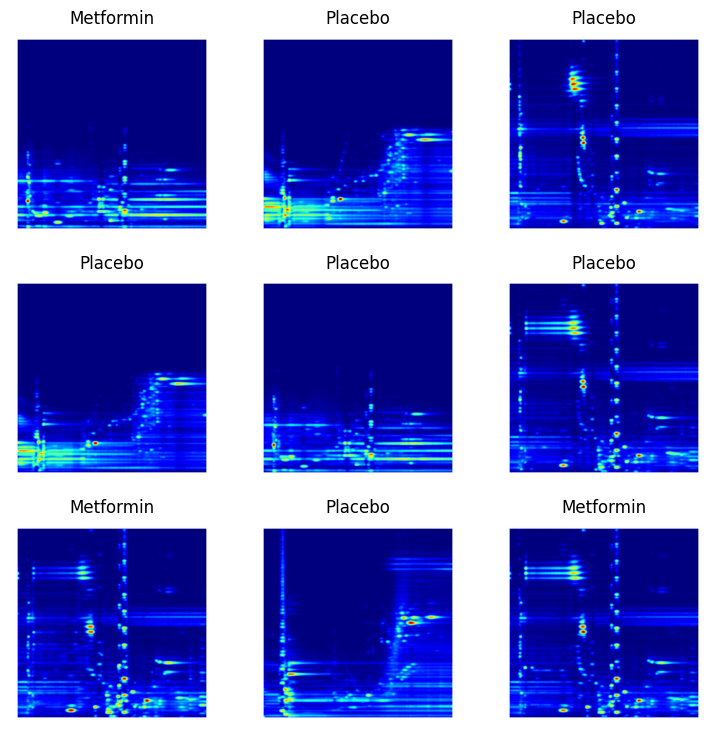

In [13]:
#loaded_samples.classes

fig = plt.figure(figsize=(9, 9))
rows, cols = 3, 3

for i in range(1, rows * cols + 1):
    fig.add_subplot(rows, cols, i)
    i = random.randint(0, len(loaded_samples))
    plt.imshow(loaded_samples[i][0].permute(1,2,0))
    # plt.title(loaded_samples[i][1])

    # title_ = 'NORMAL' if loaded_samples[i][1] == 0 else 'PNEUMONIA'
    # plt.title(title_)

    plt.title(''.join([item for item, key in train_data.class_to_idx.items() if key == loaded_samples[i][1]]))
    plt.axis(False)

plt.savefig('example_grid.png', dpi = 300)

List available pretrained models:

In [14]:
timm.list_models('efficientnet*', pretrained = True)

['efficientnet_b0.ra_in1k',
 'efficientnet_b1.ft_in1k',
 'efficientnet_b1_pruned.in1k',
 'efficientnet_b2.ra_in1k',
 'efficientnet_b2_pruned.in1k',
 'efficientnet_b3.ra2_in1k',
 'efficientnet_b3_pruned.in1k',
 'efficientnet_b4.ra2_in1k',
 'efficientnet_b5.sw_in12k',
 'efficientnet_b5.sw_in12k_ft_in1k',
 'efficientnet_el.ra_in1k',
 'efficientnet_el_pruned.in1k',
 'efficientnet_em.ra2_in1k',
 'efficientnet_es.ra_in1k',
 'efficientnet_es_pruned.in1k',
 'efficientnet_lite0.ra_in1k',
 'efficientnetv2_rw_m.agc_in1k',
 'efficientnetv2_rw_s.ra2_in1k',
 'efficientnetv2_rw_t.ra2_in1k']

In [15]:
import pytorch_lightning as pl
from timm import create_model
import torch.nn.functional as F
from pytorch_lightning.callbacks import Callback
from torchmetrics import Accuracy

class MetricsCallback(Callback):
    def __init__(self):
        super().__init__()
        self.metrics = []

    def on_validation_end(self, trainer, pl_module):
        self.metrics.append(trainer.logged_metrics)

class LitModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = create_model('convnext_xlarge_in22ft1k', pretrained=True, num_classes = 1)

        # Freeze all layers except for the last one
        for param in self.model.parameters():
            param.requires_grad = False

        self.model.head.fc = torch.nn.Sequential(
            torch.nn.Linear(in_features=2048,
                            out_features=512,
                            bias=True),
                            torch.nn.ReLU(),
                            torch.nn.Dropout(p = 0.3),
                            torch.nn.Linear(in_features=512,
                                            out_features=256,
                                            bias=True),
                            torch.nn.ReLU(),
                            torch.nn.Linear(in_features=256,
                                            out_features=1,
                                            bias=True)
        )

    def forward(self, x):
        x = self.model(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch

        loss_fn = nn.BCELoss()

        y_pred_logits = self(x).squeeze()
        y_pred = torch.sigmoid(y_pred_logits)
        loss = loss_fn(y_pred, y.float())
        self.log('train_loss', loss)

        # Calculate the accuracy
        y_pred_class = torch.round(y_pred)
        acc = (y_pred_class == y).sum().item()/len(y_pred)
        self.log('train_acc', acc)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch

        loss_fn = nn.BCELoss()

        y_pred_logits = self(x).squeeze()
        y_pred = torch.sigmoid(y_pred_logits)
        loss = loss_fn(y_pred, y.float())
        self.log('val_loss', loss)

        # Calculate the accuracy
        y_pred_class = torch.round(y_pred)
        acc = (y_pred_class == y).sum().item()/len(y_pred)
        self.log('val_acc', acc)

    def configure_optimizers(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=1e-4, weight_decay = 2e-5,)
      scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 20,
                                                             eta_min = 0)
      return [optimizer], [scheduler]

In [16]:
model = LitModel()

summary(model=model,
        input_size=(32, 3, 384, 384),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name convnext_xlarge_in22ft1k to current convnext_xlarge.fb_in22k_ft_in1k.
  model = create_fn(


model.safetensors:   0%|          | 0.00/1.40G [00:00<?, ?B/s]

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
LitModel (LitModel)                                     [32, 3, 384, 384]    [32, 1]              --                   Partial
├─ConvNeXt (model)                                      [32, 3, 384, 384]    [32, 1]              --                   Partial
│    └─Sequential (stem)                                [32, 3, 384, 384]    [32, 256, 96, 96]    --                   False
│    │    └─Conv2d (0)                                  [32, 3, 384, 384]    [32, 256, 96, 96]    (12,544)             False
│    │    └─LayerNorm2d (1)                             [32, 256, 96, 96]    [32, 256, 96, 96]    (512)                False
│    └─Sequential (stages)                              [32, 256, 96, 96]    [32, 2048, 12, 12]   --                   False
│    │    └─ConvNeXtStage (0)                           [32, 256, 96, 96]    [32, 256, 96, 96]    (1,617,408)        

In [17]:
# Resolve data configuration for the model
data_cfg = timm.data.resolve_data_config(model.model.default_cfg)

preprocess_val = timm.data.create_transform(**data_cfg, is_training = False)

# Create the transform object
preprocess_train = timm.data.create_transform(
    **data_cfg,
    is_training=True,
    re_prob=0.5,
    re_mode='pixel',
    re_count=1,
    color_jitter=0.4,
    auto_augment='rand-m9-mstd0.5-inc1',
)

In [18]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_data = datasets.ImageFolder(root = train_dir,
                                  transform = preprocess_train,
                                  target_transform = None,
                                  )

val_data = datasets.ImageFolder(root = train_dir,
                                transform = preprocess_val,
                                target_transform = None,
                                )

# train_subset = torch.utils.data.Subset(train_data, train_indices)
# val_subset = torch.utils.data.Subset(val_data, val_indices)

train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS,
                              pin_memory=True,
                              )

val_dataloader = DataLoader(val_data,
                            batch_size=BATCH_SIZE,
                            shuffle=False,
                            num_workers=NUM_WORKERS,
                            pin_memory=True,
                            )

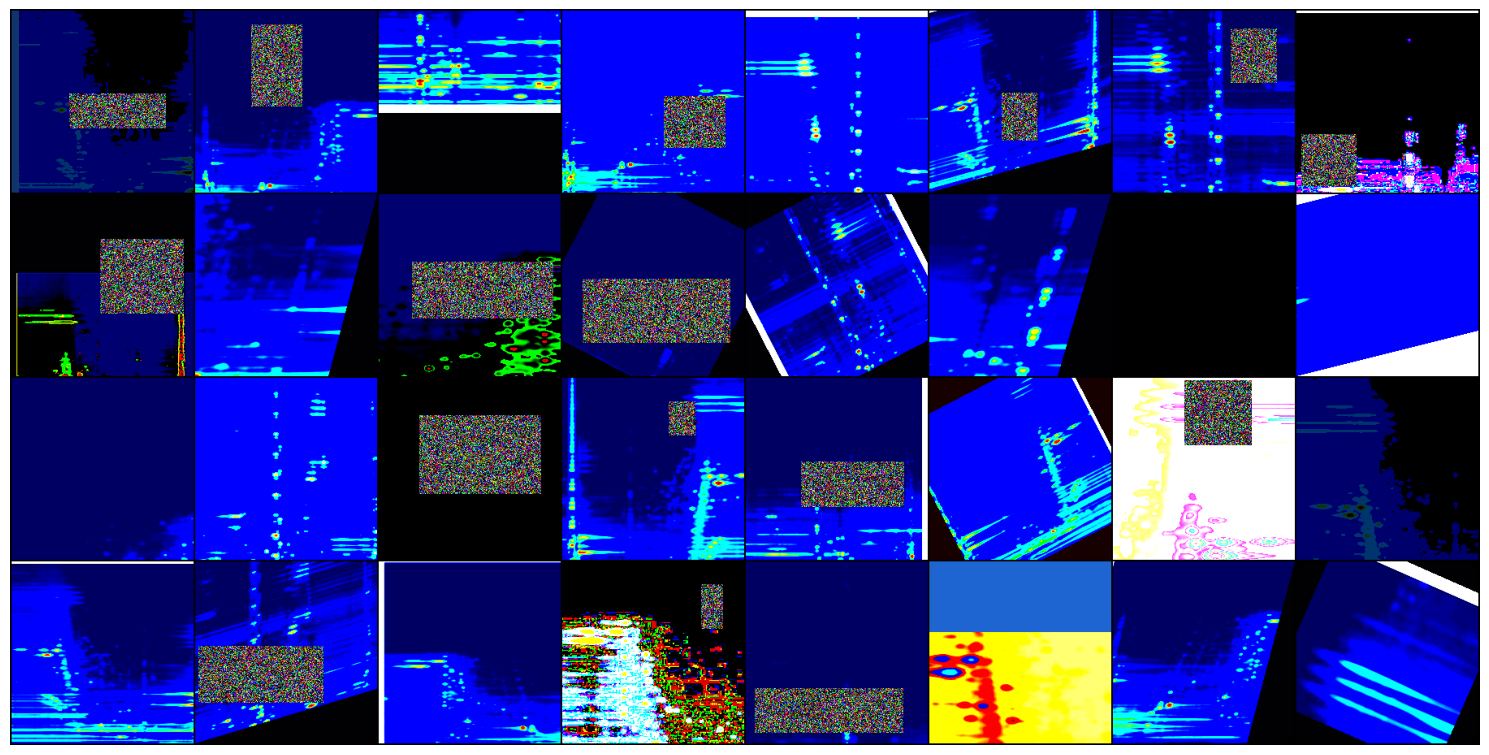

In [19]:
# train_data_positive = datasets.ImageFolder(root = train_dir,
#                                   transform = preprocess_train,
#                                   target_transform = None,
#                                   )

# train_dataloader = DataLoader(train_data_positive,
#                               batch_size=BATCH_SIZE,
#                               shuffle=True,
#                               num_workers=NUM_WORKERS,
#                               pin_memory=True,
#                               )

images, labels = next(iter(train_dataloader))
grid = make_grid(images)

plt.figure(figsize = (15,25))

img = plt.imshow(grid.permute(1, 2, 0)).figure
plt.axis('off')
plt.tight_layout()

img.savefig('transformed_grid.png', dpi = 300)

In [20]:
%reload_ext tensorboard
# %tensorboard --logdir='/content/lightning_logs' --port 5000
%tensorboard --logdir='/content/lightning_logs'

<IPython.core.display.Javascript object>

In [ ]:
# Set the CUDA_VISIBLE_DEVICES environment variable
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

metrics_callback = MetricsCallback()
# trainer = pl.Trainer(limit_train_batches=250, max_epochs=5, callbacks=[metrics_callback])

trainer = pl.Trainer(max_epochs=20, callbacks=[metrics_callback], log_every_n_steps = 1)
trainer.fit(model=model,train_dataloaders = train_dataloader, val_dataloaders = val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type     | Params
-----------------------------------
0 | model | ConvNeXt | 349 M 
-----------------------------------
1.2 M     Trainable params
348 M     Non-trainable params
349 M     Total params
1,397.315 Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]